# Experiments implementing neural networks by hand

In [43]:
import numpy as np
from numpy import typing as npt
from numpy import random as rnd
from collections.abc import Callable, Sequence
from pyclugen import clugen
import matplotlib.pyplot as plt
import time
from PIL import Image
from pathlib import Path

## Loop-based versions

The functions below are slower loop-based versions, but easier to understand, as they follow the algorithms exactly.

In [44]:
def sigm(x: float):
    """Standard logistic function."""
    return 1.0 / (1 + np.exp(np.clip(-x, -88.72, 88.72)))

In [45]:
def infer(input: npt.NDArray, nn: list[npt.NDArray]) -> list[npt.NDArray]:
    """Use a neural network to infer a classification (loop-based version)."""
    output = [input]

    for layer in range(len(nn)):
        # Don't forget about the bias
        input = np.hstack((1, output[layer]))
        
        # For each node
        nodes_output = np.zeros(nn[layer].shape[1])
        for i in range(nn[layer].shape[1]):
            o = 0
            # For each input to that node
            for j in range(nn[layer].shape[0]):

                # Multiply input by respective weight
                o += input[j] * nn[layer][j, i]
            
            # Rectify and keep output
            nodes_output[i] = sigm(o)

        output.append(nodes_output)

    return output

In [46]:
def backpropagation(
    train_input: npt.NDArray,
    train_output: npt.NDArray,
    topol: Sequence[int],
    epochs: int,
    eta: float,
    momentum: float = 0,
    hooks: Sequence[Callable[[npt.NDArray], None]] = [],
    seed: int = 123,
):
    """Backpropagation training algorithm, loop-based version."""
    rng = rnd.default_rng(seed)

    # Create fully connected feed-forward network
    nn = []
    dw = []  # Momentum
    for j in range(len(topol) - 1):
        nn.append(rng.uniform(low=-0.05, high=0.05, size=(topol[j] + 1, topol[j + 1])))
        dw.append(np.zeros((topol[j] + 1, topol[j + 1])))

    # Train!
    for _ in range(epochs):
        # Cycle through training data
        for j in range(train_input.shape[0]):
            err = []

            # Propagate the input forward through the network
            output = infer(train_input[j, :], nn)

            # Propagate the errors back through the network

            # Determine the errors for each output unit
            e = np.zeros(topol[-1])
            for k in range(topol[-1]):
                ok = output[-1][k]
                e[k] = ok * (1 - ok) * (train_output[j, k] - ok)
            err.insert(0, e)

            # For each hidden layer...
            for layer in np.arange(len(nn) - 1, 0, -1):
                # ...determine the error of each of its units
                e = np.zeros(topol[layer])
                for h in range(topol[layer]):
                    oh = output[layer][h]
                    e[h] = oh * (1 - oh) * np.sum(nn[layer][h + 1, :] * err[0])
                err.insert(0, e / topol[layer])

            # Update the network weights
            for layer in range(len(nn)):
                for i_ji in range(nn[layer].shape[0]):
                    for j_ji in range(nn[layer].shape[1]):
                        dw[layer][i_ji, j_ji] = (
                            eta * err[layer][j_ji] * np.hstack((1, output[layer]))[i_ji]
                            + momentum * dw[layer][i_ji, j_ji]
                        )
                        nn[layer][i_ji, j_ji] += dw[layer][i_ji, j_ji]

        # Invoke hooks
        for hook in hooks:
            hook.register(nn, infer)

    return nn

## Vectorized versions

The functions below are faster versions vectorized with NumPy, which might not be so easy to follow.

In [47]:
# Vectorized standard logistic function
vsigm = np.vectorize(sigm)

In [48]:
def vinfer(input: npt.NDArray, nn: list[npt.NDArray]) -> list[npt.NDArray]:
    """Use a neural network to infer a classification (vectorized version)."""
    output = [input]

    for layer in range(len(nn)):

        # Don't forget about the bias
        input = np.hstack((1, output[layer]))
        
        output.append(vsigm(input @ nn[layer]))

    return output

In [49]:
def vbackpropagation(
    train_input: npt.NDArray,
    train_output: npt.NDArray,
    topol: Sequence[int],
    epochs: int,
    eta: float,
    momentum: float = 0,
    hooks: Sequence[Callable[[npt.NDArray], None]] = [],
    seed: int = 123,
):
    """Backpropagation training algorithm, vectorized version."""
    rng = rnd.default_rng(seed)

    # Create fully connected feed-forward network
    nn = []
    dw = []  # Momentum
    for j in range(len(topol) - 1):
        nn.append(rng.uniform(low=-0.05, high=0.05, size=(topol[j] + 1, topol[j + 1])))
        dw.append(np.zeros((topol[j] + 1, topol[j + 1])))

    # Train!
    for _ in range(epochs):
        # Cycle through training data
        for j in range(train_input.shape[0]):
            err = []

            # Propagate the input forward through the network
            output = vinfer(train_input[j, :], nn)

            # Propagate the errors back through the network

            # Determine the errors for each output unit
            err.insert(
                0, output[-1] * (1 - output[-1]) * (train_output[j, :] - output[-1])
            )

            # For each hidden layer...
            for layer in np.arange(len(nn) - 1, 0, -1):
                # ...determine the error of each of its units
                o = output[layer]
                sumult = nn[layer][1:, :] @ err[0]
                err.insert(0, o * (1 - o) * (sumult / len(o)))

            # Update the network weights
            for layer in range(len(nn)):
                dw[layer] = (
                    eta
                    * (
                        np.hstack((1, output[layer])).reshape((-1, 1))
                        @ err[layer].reshape((1, -1))
                    )
                    + momentum * dw[layer]
                )
                nn[layer] += dw[layer]

        # Invoke hooks
        for hook in hooks:
            hook.register(nn, vinfer)

    return nn

In [50]:
def categ2oneofn(
    categ_data: npt.NDArray, node_off: float, node_on: float
) -> tuple[npt.NDArray, dict]:
    """Convert categorical labels to 1-of-n output encoding format."""
    categs = np.unique(categ_data)
    ncategs = len(categs)

    mapping = {}
    for i in range(ncategs):
        mapping[categs[i]] = node_off * np.ones(ncategs)
        mapping[categs[i]][i] = node_on

    nn_output = np.array([mapping[categ] for categ in categ_data])

    return nn_output, mapping

In [51]:
def oneofn2categ(oneofn: npt.NDArray, mapping: dict, node_off: float, node_on: float):
    """Return a category given a 1-of-n output encoding."""
    oneofn_fix = node_off * np.ones(len(oneofn))
    oneofn_fix[np.argmax(oneofn)] = node_on

    for categ, encod in mapping.items():
        if np.all(encod == oneofn_fix):
            return categ
        
    return None

## Accuracy register code

The below code is used to keep track of accuracy during training, as well as for plotting accuracy evolution.

In [52]:
def calc_accuracy(expected: npt.NDArray, actual: npt.NDArray) -> float:
    """Determine accuracy (0-1)."""
    correct = np.sum(np.apply_along_axis(np.all, 1, actual == expected))
    return correct / expected.shape[0]

In [53]:
class AccuracyRegister:
    """Use this for keeping track of accuracy evolution during training."""

    def __init__(
        self,
        test_data: npt.NDArray,
        expect_out: npt.NDArray,
        epochs: int,
        node_off: float,
        node_on: float,
    ):
        self.test_data = test_data
        self.expect_out = expect_out
        self.epoch = 0
        self.node_off = node_off
        self.node_on = node_on
        self.accuracies = np.zeros(epochs)

    def register(self, nn: npt.NDArray, linfer: Callable):
        """Determine accuracy after current epoch."""
        actual_out = self.node_off * np.ones(self.expect_out.shape)
        for j in range(actual_out.shape[0]):
            result = linfer(self.test_data[j, :], nn)[-1]
            actual_out[j, np.argmax(result)] = self.node_on

        self.accuracies[self.epoch] = calc_accuracy(self.expect_out, actual_out)
        self.epoch += 1

In [54]:
def plot_accuracy(epochs: int, accuracies: dict[str, npt.NDArray], title: str = ""):
    """Plot accuracy during training."""
    fig, ax = plt.subplots()
    for label, fits in accuracies.items():
        ax.plot(range(0, epochs), fits, label=label)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()
    if len(title) > 0:
        fig.suptitle(title)

## Create train and test data with pyclugen

Text(0.5, 0.92, 'Test data')

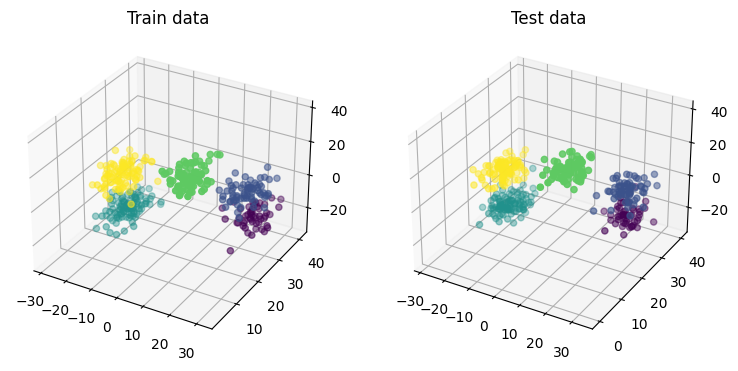

In [55]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Generate test data, based on parameters from train data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions,  # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Use final values from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths,
)

# Plot the train and test data
_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
axs[0].set_title("Train data")
axs[1].scatter(
    data_test.points[:, 0],
    data_test.points[:, 1],
    data_test.points[:, 2],
    c=data_test.clusters,
)
axs[1].set_title("Test data")

## Experiments

In [56]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)
clunn_test, _ = categ2oneofn(data_test.clusters, node_off, node_on)

### Quickly compare loop-based and vectorized versions of backpropagation and inference

Backpropagation using loops: 19.739124745 seconds
Vectorized backpropagation : 7.945517274 seconds
Vectorization speedup vs loop-based : 2.48x


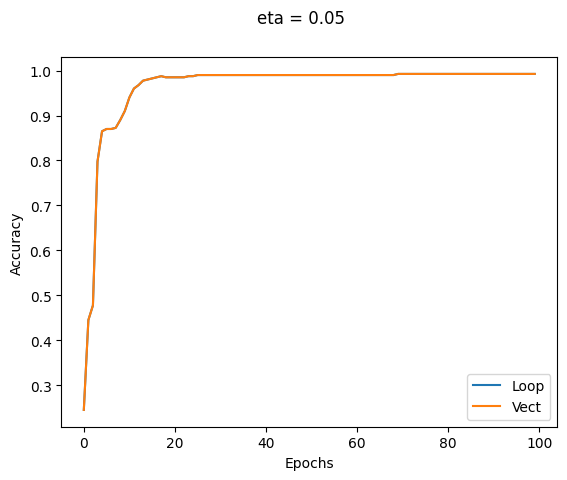

In [57]:
# Backpropagation parameters
epochs = 100
eta = 0.05
mom = 0.1
topol = [ndims, 12, nclu]

# Prepare hooks for registering accuracy
fitreg_loop = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_vect = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)

# Test loop-based backpropagation
time_start = time.time_ns()
backpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_loop]
)
duration_loop = time.time_ns() - time_start
print(f"Backpropagation using loops: {duration_loop / 1e9} seconds")

# Test vectorized backpropagation
time_start = time.time_ns()
vbackpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_vect]
)
duration_vect = time.time_ns() - time_start
print(f"Vectorized backpropagation : {duration_vect / 1e9} seconds")

# Speedup loop-based vs vectorized
print(f"Vectorization speedup vs loop-based : {duration_loop / duration_vect:.2f}x")

# Plot accuracy
plot_accuracy(
    epochs,
    {
        "Loop": fitreg_loop.accuracies,
        "Vect": fitreg_vect.accuracies,
    },
    f"eta = {eta}",
)

### Train with train data, determine accuracy with test data

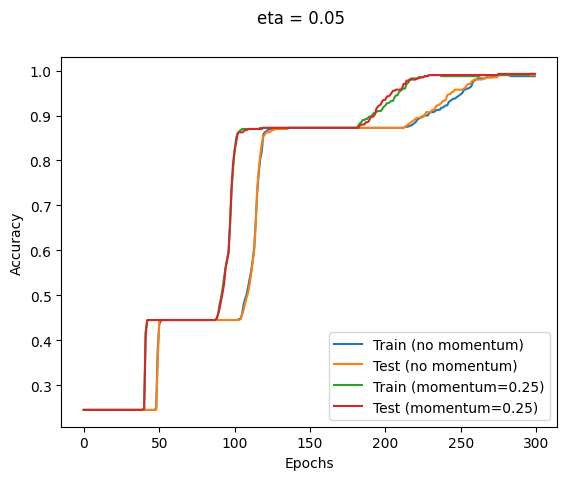

In [58]:
# Backpropagation parameters
epochs = 300
eta = 0.05
mom = 0.25
topol = [ndims, 18, 18, nclu]

# Prepare hooks for registering accuracy
fitreg_train = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_test = AccuracyRegister(data_test.points, clunn_train, epochs, node_off, node_on)
fitreg_train_m = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_test_m = AccuracyRegister(
    data_test.points, clunn_train, epochs, node_off, node_on
)

# Perform backpropagation without and with momentum
nn1 = vbackpropagation(
    data_train.points,
    clunn_train,
    topol,
    epochs,
    eta,
    hooks=[fitreg_train, fitreg_test],
)
nn2 = vbackpropagation(
    data_train.points,
    clunn_train,
    topol,
    epochs,
    eta,
    mom,
    hooks=[fitreg_train_m, fitreg_test_m],
)

# Plot accuracy
plot_accuracy(
    epochs,
    {
        "Train (no momentum)": fitreg_train.accuracies,
        "Test (no momentum)": fitreg_test.accuracies,
        f"Train (momentum={mom})": fitreg_train_m.accuracies,
        f"Test (momentum={mom})": fitreg_test_m.accuracies,
    },
    f"eta = {eta}",
)

## Experiment with Tom Mitchell's image data set

This data set is available at <https://www.cs.cmu.edu/afs/cs.cmu.edu/user/mitchell/ftp/faces.html>.

### Load image data set

In [59]:
# Number of pixels in each image
n_pixels = 30 * 32

# Obtain list of image files
img_path = Path('../data')
img_files = list(img_path.glob('**/*.pgm'))
n_imgs = len(img_files)

# Determine image categories based on their respective filenames
img_classes = np.array([img_file.stem.split('_')[1:-1] for img_file in img_files])

print(f"Looking   : {np.unique(img_classes[:, 0])}")
print(f"Emotions  : {np.unique(img_classes[:, 1])}")
print(f"Sunglasses: {np.unique(img_classes[:, 2])}")

looking_classes, looking_map = categ2oneofn(img_classes[:, 0], node_off, node_on)
emotion_classes, emotion_map = categ2oneofn(img_classes[:, 1], node_off, node_on)
sunglas_classes, sunglas_map = categ2oneofn(img_classes[:, 2], node_off, node_on)

# Load the images into a numpy array
img_data = np.zeros((n_imgs, n_pixels))

for i in range(len(img_files)):
    with Image.open(img_files[i]) as img:
        img_data[i, :] = list(img.getdata())

# Normalize image data between 0 and 1
img_data /= 255

Looking   : ['left' 'right' 'straight' 'up']
Emotions  : ['angry' 'happy' 'neutral' 'sad']
Sunglasses: ['open' 'sunglasses']


### Train for detecting looking direction

Image data:  (624, 960)
Class data:  (624, 4)


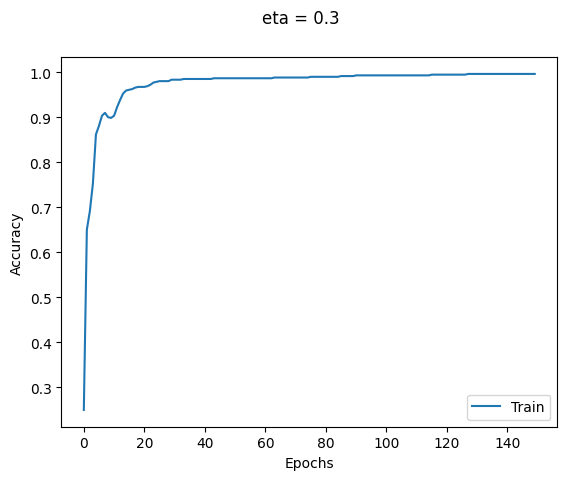

In [60]:
# Backpropagation parameters
epochs = 150
eta = 0.3
mom = 0.3
topol = [n_pixels, 3, 4] # Looking == 4 directions

print("Image data: ", img_data.shape)
print("Class data: ", looking_classes.shape)

# Prepare hooks for registering accuracy
fitreg_img_train = AccuracyRegister(
    img_data, looking_classes, epochs, node_off, node_on
)

# Perform backpropagation
img_classifier = vbackpropagation(
    img_data,
    looking_classes,
    topol,
    epochs,
    eta,
    hooks=[fitreg_img_train],
)

# Plot accuracy
plot_accuracy(
    epochs,
    {
        "Train": fitreg_img_train.accuracies,
    },
    f"eta = {eta}",
)

In [61]:
# Check that it classifies images correctly
rng = np.random.default_rng(234)

rand_img_idxs = rng.integers(n_imgs, size=5)

for img_idx in rand_img_idxs:
    with Image.open(img_files[img_idx]) as img:
        result = vinfer(list(img.getdata()), img_classifier)[-1]
        print(oneofn2categ(result, looking_map, node_off, node_on))
        display(img)

right


right


up


straight


up
